# Earthquake seismology with DAS

#### Todo List:
1. Reference earthquakes by Evid rather than dataframe index
2. Make a map of all of the detected events
3. Try some xcorr

In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import sintela_to_datetime, open_sintela_file, local_earthquake_quicklook, data_wrangler, haversine
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
import geopy.distance
from obspy.taup import TauPyModel
import math

ERROR 1: PROJ: proj_create_from_database: Open of /home/velgueta/.conda/envs/python-obspy/share/proj failed


### Get a list of events from USGS

In [ ]:
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime(2023,1,7,0,0),
                minmagnitude=4.5,
                maxmagnitude=5.5,
                maxradiuskm=3000, 
                latitude=47.60,
                longitude=-122.33)

print("Returned %s events" % len(events))
 
 

# Choose an event to analyze

In [ ]:
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['time'],ascending=False)
event_df



#event_df.iloc[0::]

# Loading data

In [9]:
df0=pd.read_csv('Catalogo600km3to5mw.csv')
df0
df=pd.read_csv('Catalog-Whidbey-lowmagnitud.csv')  
df
dff1=pd.read_csv('Catalogwhidbey24to27.csv')
dff1
dff2=pd.read_csv('whidbeyhiguestamplitudin1000.csv')
dff3=pd.read_csv('Catalogwhidbey24to27.csv')
dff3
dff4=pd.read_csv('Catalogwhidbey239to20.csv')
dff4
dff5=pd.read_csv('Catalogwhidbey199to17.csv')
dff6=pd.read_csv('Catalogwhidbey169to14.csv')
dff7=pd.read_csv('Catalogwhidbeyglobal67plus.csv')
dff8=pd.read_csv('Catalogwhidbey50to6692500km.csv')
dff9=pd.read_csv('Catalogwhidbey45to55in3000km.csv')
dff10 = pd.read_csv('Catalogwhidbey57toinfin8000km.csv')
dff11clip = pd.read_csv('Catalogwhidbeyclipped.csv')


# Concat dataframes

In [11]:
#test2 = pd.read_csv('Catalogwhidbey24to27.csv')
#test2
#test2[test  0] = np.NAN
##test2.fillna(1)
#test2
#test2.clipped = test2.clipped.fillna()
#clipped_data = test2[test2.clipped == 'False']
#clipped_data


In [12]:
testconcat =  pd.concat([df0,df,dff1,dff2,dff3,dff4,dff5,dff6,dff7,dff8,dff9,dff10], ignore_index = True)
testconcat.shape

(575, 8)

In [ ]:
testconcat.head()

In [ ]:
cleandata = testconcat[testconcat.duplicated()]
cleandata

# dropping duplicates

In [13]:
cleandata_2 = testconcat.drop_duplicates()

cleandata_2

,Magnitud,id_event,Location,detect_seismO,detect_das,clipped,channels,Clipped
0,3.9,us7000j3g5,496.372832,True,FALSE,False,NaN,NaN
1,3.8,us7000j3f8,495.275940,True,FALSE,False,NaN,NaN
2,4.9,us7000ishe,332.678725,False,TRUE,NaN,NaN,NaN
3,4.4,us7000iqsk,583.335379,True,TRUE,True,NaN,NaN
4,3.4,us7000imha,602.592266,True,norecord,False,NaN,NaN
...,...,...,...,...,...,...,...,...
570,5.6,us7000h5t8,6019.151401,NaN,norecord,NaN,NaN,NaN
571,5.6,us6000hfyj,6128.533347,NaN,norecord,NaN,NaN,NaN
572,6.6,us6000hf75,5183.086145,NaN,INCONCLUSIVE,NaN,NaN,NaN
573,5.7,us7000h0x9,4181.059974,NaN,FALSE,NaN,NaN,NaN


# Sellect data to plot

In [14]:
sele_rowcleandata = cleandata_2[cleandata_2.detect_das =='TRUE']
nosele_rowcleandata = cleandata_2[cleandata_2.detect_das =='FALSE']
inconclu_data = cleandata_2[cleandata_2.detect_das == 'INCONCLUSIVE']


In [ ]:
#sanity check
#nosele_rowcleandata
#inconclu_data
#clipped_data
#inconclu_data
cleandata_2.clipped


# Plotting data selected

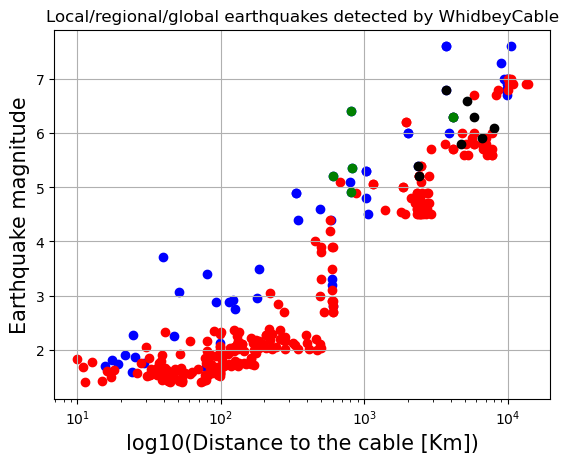

In [17]:
ax=plt.plot(figsize=(25,25))
a=0.5
ax=plt.scatter(sele_rowcleandata.Location, sele_rowcleandata.Magnitud,c='b', s=None, marker='o')
ax=plt.scatter(nosele_rowcleandata.Location, nosele_rowcleandata.Magnitud,c='r', s=None, marker='o')
ax=plt.scatter(inconclu_data.Location, inconclu_data.Magnitud,c='k', s=None, marker='o')
ax=plt.scatter(dff11clip.Location, dff11clip.Magnitud,c='g', s=None, marker='o')
ax=plt.xscale('log')
ax=plt.ylabel('Earthquake magnitude', fontsize=15);
ax=plt.xlabel('log10(Distance to the cable [Km])',fontsize=15)
ax=plt.grid()
ax=plt.title('Local/regional/global earthquakes detected by WhidbeyCable')
ax =plt.savefig("whidbeylocalquakesmw-all")
ax = plt.show()
ax = plt.close()

In [ ]:
selected_rows0 = df0[df0.detect_das == 'TRUE']
noselected_rows0 = df0[df0.detect_das == 'FALSE']
selected_rows1 = dff1[dff1.detect_das == 'TRUE']
noselected_rows1 = dff1[dff1.detect_das == 'FALSE']
selected_rows = df[df.detect_das == 'TRUE']
noselected_rows = df[df.detect_das == 'FALSE']
selected_rows2 = dff2[dff2.detect_das == 'TRUE']
noselected_rows2 = dff2[dff2.detect_das == 'FALSE']
selected_rows3 = dff3[dff3.detect_das == 'TRUE']
noselected_rows3 = dff3[dff3.detect_das == 'FALSE']
selected_rows4 = dff4[dff4.detect_das == 'TRUE']
noselected_rows4 = dff4[dff4.detect_das == 'FALSE']
selected_rows5 = dff5[dff5.detect_das == 'TRUE']
noselected_rows5 = dff5[dff5.detect_das == 'FALSE']
selected_rows6 = dff6[dff6.detect_das == 'TRUE']
noselected_rows6 = dff6[dff6.detect_das == 'FALSE']
selected_rows7 = dff7[dff7.detect_das == 'TRUE']
noselected_rows7 = dff7[dff7.detect_das == 'FALSE']
#plt.scatter(np.log10(selected_rows.Location),selected_rows.Magnitud,s=None, marker='o', alpha=0.9, label='Different earthquakes')
#plt.xlabel('log10(Distance to the cable(Km))')
#plt.ylabel('Magnitud')
#plt.title('Whidbey detection (magnitudes between 2.7 to 2.99 mw)')
#plt.grid()
#plt.savefig("whidbeylocalquakes-lowmagnitud")
#plt.show()
#plt.close()

In [ ]:
#plot testing
#creating plot distance vs magnitud
#plt.subplots(figsize=(10,5))
#plt.scatter(np.log10(dist_kmarray), magnituddarray,s=None, marker='o', alpha=0.9, label='Different earthquakes')
#plt.xlabel('Distance to the cable [Km]')
#plt.ylabel('Earthquakes magnitud');
#plt.legend()
#plt.grid()
#plt.show()

# Data frame for earthquakes with WhibdeyCable

In [ ]:
#these lines replaced for df0 folder
#tf=['False','False','True','True','norecord','True','False','True','True','True','False','True','True','False','False','False','False','False','False','True','Norecord','Norecord','False','True','Norecord','Norecord','True','False']
#tfn=np.array(tf).T
#len(tf)
#dataf = np.array([event_df.id, event_df.location, event_df.magnitude,tf],dtype='object').T
#dataf
#df3 = pd.DataFrame(dataf,columns=['Id', 'Distance', 'Magnitude','Detected by Das'])
#df3



In [ ]:
#creating plot distance vs magnitud (real earthquakes that we can see)
#newmagtnitud=[magnituddarray[2],magnituddarray[3],magnituddarray[5],magnituddarray[7],magnituddarray[8],magnituddarray[10],magnituddarray[11],magnituddarray[13],magnituddarray[14],magnituddarray[18],magnituddarray[19],magnituddarray[23],magnituddarray[26]]
#newdist_kmarray=[dist_kmarray[2],dist_kmarray[3],dist_kmarray[5],dist_kmarray[7],dist_kmarray[8],dist_kmarray[10],dist_kmarray[11],dist_kmarray[13],dist_kmarray[14],dist_kmarray[18],dist_kmarray[19],dist_kmarray[23],dist_kmarray[26]]
#filename = f"earthquakes_distances600noseismogramswhidbey/"
a=0.5
figure=plt.plot(figsize=(15,20))
plt.scatter(selected_rows0.Location,selected_rows0.Magnitud,c='b', s=None, marker='o', alpha=a, label='Quakes detected by Das')
plt.scatter(noselected_rows0.Location,noselected_rows0.Magnitud,c='r', s=None, marker='o', alpha=a)# label='Earthquakes magnitud from 3.0mw No detected')
#plt.scatter(newdist_kmarray,newmagtnitud,s=None, marker='o', alpha=0.9, label='Earthquakes magnitud from 3.0mw')
plt.scatter(noselected_rows.Location,noselected_rows.Magnitud,c='r',s=None, marker='o', alpha=a)# label='Earthquakes magnitud from 2.7 to 3mw NO DETECTED')
plt.scatter(selected_rows.Location,selected_rows.Magnitud,c='b',s=None, marker='o', alpha=a) # label='Earthquakes magnitud from 2.7 to 3mw')
plt.scatter(selected_rows1.Location,selected_rows1.Magnitud,c='b',s=None, marker='o', alpha=a)# label='Earthquakes magnitud from 1.5 to 2.7mw')
plt.scatter(noselected_rows1.Location,noselected_rows1.Magnitud,c='r',s=None, marker='o', alpha=a)# label='nodetected Earthquakes magnitud from 1.5 to 2.7mw')
#plt.scatter(dff2.Location,dff2.Magnitud,c='b',s=None, marker='o', alpha=0.9, label='Earthquakes magnitud from 4.9 to 8mw')
plt.scatter(selected_rows2.Location,selected_rows2.Magnitud,c='b',s=None, marker='o', alpha=a)# label='Earthquakes magnitud from 4.9 to 8mw')
plt.scatter(noselected_rows2.Location,noselected_rows2.Magnitud,c='r',s=None, marker='o', alpha=a)# label='no detected Earthquakes ')
plt.scatter(dff3.Location,dff3.Magnitud,c='b',s=None, marker='o', alpha=0.9)#, label='Earthquakes magnitud from 4.9 to 8mw')
plt.scatter(noselected_rows3.Location,noselected_rows3.Magnitud,c='r',s=None, marker='o', alpha=a)# label='Earthquakes magnitud from 4.9 to 8mw')
plt.scatter(dff4.Location,dff4.Magnitud,c='b',s=None, marker='o', alpha=0.9)#, label='Earthquakes magnitud from 4.9 to 8mw')
plt.scatter(noselected_rows4.Location,noselected_rows4.Magnitud,c='r',s=None, marker='o', alpha=a)# label='Earthquakes magnitud from 4.9 to 8mw')
plt.scatter(dff5.Location,dff5.Magnitud,c='b',s=None, marker='o', alpha=0.9)#, label='Earthquakes magnitud from 4.9 to 8mw')
plt.scatter(noselected_rows5.Location,noselected_rows5.Magnitud,c='r',s=None, marker='o', alpha=a)# label='Earthquakes pequeños')
plt.scatter(dff6.Location,dff6.Magnitud,c='b',s=None, marker='o', alpha=0.9)#, label='Earthquakes magnitud from 4.9 to 8mw')
plt.scatter(noselected_rows6.Location,noselected_rows6.Magnitud,c='r',s=None, marker='o', alpha=a)
plt.scatter(dff7.Location,dff7.Magnitud,c='b',s=None, marker='o', alpha=0.9)# label='Earthquakes magnitud from 4.9 to 8mw')
plt.scatter(noselected_rows7.Location,noselected_rows7.Magnitud,c='r',s=None, marker='o', alpha=a,label='NO detected')
plt.title('old plot-dataduplicated')
plt.xscale('log')
plt.xlabel('log10(Distance to the cable [Km])',fontsize=15)
plt.ylabel('Earthquake magnitude', fontsize=15);
plt.legend()
plt.grid()
#plt.savefig(filename+"_whidbeylocalquakes")
plt.savefig("whidbeylocalquakesmw-all")
plt.show()
plt.close()